In [2]:
# pytorch LSTM for regression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from torch import Tensor,nn
from torch.nn import Linear, Sigmoid, Module
from torchkeras import summary
import torch, gensim
torch.manual_seed(3)
from Data_Utils import *
from Plot_Utils import *

torch.autograd.set_detect_anomaly(True)

# pytorch LSTM for regression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from torch import Tensor,nn
from torch.nn import Linear, Sigmoid, Module
from torchkeras import summary
import torch, gensim
torch.manual_seed(3)
from Data_Utils import *
from Plot_Utils import *
from Math_Utils import *
torch.autograd.set_detect_anomaly(True)
#LSTM(sequence_len,batchsize,dim)


class RNN(Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.rnn = torch.nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,)
        self.output_layer = Linear(in_features=hidden_size, out_features=output_size)

    def forward(self, x, h_state):
        rnn_out, h_state = self.rnn(x, h_state)   # h_state是之前的隐层状态
        out = []
        #for m in self.modules():
        #    if isinstance(m, Linear):
        #        m.weight.data.normal_(0, 1)
        #        print(m)
        #        m.bias.data.zero_()
        #    elif isinstance(m, nn.BatchNorm3d):
        #        m.weight.data.fill_(1)
        #        m.bias.data.zero_()
        for time in range(rnn_out.size(1)):
            every_time_out = rnn_out[:, time, :]       # 相当于获取每个时间点上的输出，然后过输出层
            out.append(self.output_layer(every_time_out))
        return torch.stack(out, dim=1), h_state       # torch.stack扩成[1, output_size, 1]

class LCrnn:
    def __init__(self,Dataset,steps,gap):
        self.Dataset=Dataset
        self.steps=steps
        self.gap=gap
        self.lam=0.5
        self.lr=0.0001
        self.weight_decay=1e-5
        self.epoch=300
        self.InputSet,self.TargetSet=Id2Id(self.Dataset.train_dl,gap)

    def train_rnn(self,model,save_path='C:/Aczh work place/3_paper/SCNRL_Master/baseline/rnn_model_2.pkl'):
        train_dl=self.Dataset.train_dl
        gap=self.gap
        steps=self.steps
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.2,weight_decay=0.001)
        regularization_loss,t = 0,len(train_dl)//steps
        loss_res=[]
        for epoch in range(15):
            for step in range(steps):
                data=train_dl[step*t:(step+1)*t]
                is_cycle,cycles=fftTransfer(data,10,0.02)
                print('datashape is',data.shape)
                data = torch.from_numpy(cycles)
                print('.........................................')
                print('Now we strat to train epoch:',epoch,'step is',step)
                h_state = None  # 初始化隐藏层状态
                #h0 = model.init_hidden(DS.train_dl.shape[1])
                for i in range(t//gap-2):
                    model.zero_grad()
                    inputs = data[i*gap:i*gap+gap,:].reshape(-1,gap,self.Dataset.dim)
                    targets = data[i*gap+gap:(i+2)*gap,:].reshape(-1,gap,self.Dataset.dim)
                    #print(inputs)
                    #print('inputs.size is',inputs.shape)
                    yhat, h_state = model(inputs, h_state)
                    h_state = h_state.detach()
                    loss = L2_loss(yhat, targets)
                    loss.backward(retain_graph=True)
                    optimizer.step()
                    #for name in model.state_dict():
                    #    if ('weight_hh') in name:
                    #        print('weight',name,'less than 1')
                    #        model.state_dict()[name]=torch.div(model.state_dict()[name],torch.norm(model.state_dict()[name],p='fro'))
                    #        print(torch.norm(model.state_dict()[name], p='fro', dim=None, keepdim=False, out=None, dtype=None))
                print('yhat.shape is',yhat.shape)
                print('Now the loss=',loss)
            loss_res.append(float(loss.detach().numpy()))
            torch.save(model, save_path)
            print('Model has been saved')
            if epoch>3 and (loss_res[epoch-1]-loss_res[epoch-2])<0.0001:
                print(summary(model))
                break

    def plot_time_series_model(self, model,gap):
        time=DS.time[0:len(DS.time):gap].reshape(-1,1)
        print(len(time))
        ori_data=self.Dataset.transform_back(self.Dataset.ori_data,'ori2train')
        #plt.show()
        x_0=self.Dataset.ori_data[0,:]
        path_all = []
        h_state = None
        yhat=[]
        data=ori_data
        #is_cycle,cycles=fftTransfer(data,10,0.02)
        yf = abs(np.fft.fft(data))  # 取绝对值
        yfnormlize = yf / len(data)  
        data = yfnormlize.astype(np.float32)      
        print('datashape is',data.shape)
        for i in range(len(time)):
            inputs = data[i*gap:i*gap+gap,:].reshape(-1,gap,self.Dataset.dim)
            x_0 = torch.from_numpy(inputs)
            yhat,h_state == model(x_0, h_state)
            yhat = yhat.detach().numpy()
            #path_all.append(list(self.Dataset.transform_back(yhat[0],'train2back')))
            path_all.append(yhat[0])
        for dim in range(45):
            print(dim)
            plt.plot(time, ori_data[:len(self.Dataset.ori_data)//20:gap, dim])
            plt.show()
            plt.plot(time,[i[dim] for i in path_all])
            plt.show()
        print('Over Now')
        return path_all


def load_model(save_path):
    model = torch.load(save_path)
    return model


def predict(row, model):
    # convert row to data
    try:
        row = torch.tensor([row],requires_grad=True,dtype=torch.float32)
        #row = torch.Tensor([row])
    except:
        print('row is Tensor already')
    # make prediction
    #yhat = sum([model[i](row) for i in range(len(model))])/len(model)
    yhat=model(row)
    # retrieve numpy array
    if isinstance(yhat, tuple):
        ghat=np.array([yhat[i].detach().numpy() for i in range(len(yhat))]).flatten().reshape(len(yhat[0]),2)
        return ghat
    yhat = yhat.detach().numpy()
    return yhat    

if __name__ == "__main__":
    data_path='C:/Aczh work place/3_paper/SNCRL_Dataset/CellCycle/'
    DS=Dataset(data_path,1)
    steps,gap=140,10
    target_size=DS.dim
    num_layers = 3
    input_size=DS.dim
    hidden_size=DS.dim*3



C:\Anaconda\lib\site-packages\setuptools\distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "
C:\Anaconda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be im

successly load time
(1400000, 44) (600000, 44) (100000, 44)
self.train_dl (1400000, 44)


In [3]:
import tensorflow as tf
import torch
from torch.autograd import Variable
import torch.optim as optim
signal_length = 32
# Initialise weight vector to train:
W_learned = Variable(torch.from_numpy(np.random.random([signal_length, 2 * signal_length]) - 0.5),requires_grad=True)
# Expected weights, for comparison:
W_expected = create_fourier_weights(signal_length)
learning_rate=0.01
losses = []
rmses = []
for i in range(2000):
    if i%50==1:
        print(i)
        print('now the epoch,',str(i),'with loss ',loss)
    # Generate a random signal each iteration:
    x = np.random.random([1, signal_length]) - 0.5
    # Compute the expected result using the FFT:
    fft = np.fft.fft(x)
    y_true = torch.from_numpy(np.hstack([fft.real, fft.imag]))
    y_pred = torch.matmul(torch.from_numpy(x), W_learned)
    loss = torch.sum(torch.square(y_pred - y_true))
    loss.backward()
    W_learned = Variable(W_learned - learning_rate * W_learned.grad.data,requires_grad=True)
    losses.append(loss)
    #rmses.append(np.sqrt(np.mean((W_learned - W_expected)**2)))


NameError: name 'create_fourier_weights' is not defined

(1000, 1) (1, 1000)
arg_vals shape is torch.Size([1000, 1000])
1
now the epoch, 1 with loss  tensor(266.4781, grad_fn=<SumBackward0>)
101
now the epoch, 101 with loss  tensor(0.0023, grad_fn=<SumBackward0>)
201
now the epoch, 201 with loss  tensor(3.3933e-08, grad_fn=<SumBackward0>)
1
now the epoch, 1 with loss  tensor(5.5246, grad_fn=<SumBackward0>)
101
now the epoch, 101 with loss  tensor(4.5372, grad_fn=<SumBackward0>)
201
now the epoch, 201 with loss  tensor(3.7263, grad_fn=<SumBackward0>)
301
now the epoch, 301 with loss  tensor(3.0603, grad_fn=<SumBackward0>)
401
now the epoch, 401 with loss  tensor(2.5133, grad_fn=<SumBackward0>)
501
now the epoch, 501 with loss  tensor(2.0641, grad_fn=<SumBackward0>)
601
now the epoch, 601 with loss  tensor(1.6952, grad_fn=<SumBackward0>)
701
now the epoch, 701 with loss  tensor(1.3922, grad_fn=<SumBackward0>)
801
now the epoch, 801 with loss  tensor(1.1434, grad_fn=<SumBackward0>)
901
now the epoch, 901 with loss  tensor(0.9390, grad_fn=<SumBa

1701
now the epoch, 1701 with loss  tensor(0.2736, grad_fn=<SumBackward0>)
1801
now the epoch, 1801 with loss  tensor(0.2703, grad_fn=<SumBackward0>)
1901
now the epoch, 1901 with loss  tensor(0.2669, grad_fn=<SumBackward0>)
2001
now the epoch, 2001 with loss  tensor(0.2636, grad_fn=<SumBackward0>)
2101
now the epoch, 2101 with loss  tensor(0.2603, grad_fn=<SumBackward0>)
2201
now the epoch, 2201 with loss  tensor(0.2571, grad_fn=<SumBackward0>)
2301
now the epoch, 2301 with loss  tensor(0.2539, grad_fn=<SumBackward0>)
2401
now the epoch, 2401 with loss  tensor(0.2508, grad_fn=<SumBackward0>)
2501
now the epoch, 2501 with loss  tensor(0.2477, grad_fn=<SumBackward0>)
2601
now the epoch, 2601 with loss  tensor(0.2446, grad_fn=<SumBackward0>)
2701
now the epoch, 2701 with loss  tensor(0.2416, grad_fn=<SumBackward0>)
2801
now the epoch, 2801 with loss  tensor(0.2386, grad_fn=<SumBackward0>)
2901
now the epoch, 2901 with loss  tensor(0.2356, grad_fn=<SumBackward0>)
3001
now the epoch, 3001 

801
now the epoch, 801 with loss  tensor(1.0444, grad_fn=<SumBackward0>)
901
now the epoch, 901 with loss  tensor(0.9786, grad_fn=<SumBackward0>)
1001
now the epoch, 1001 with loss  tensor(0.9169, grad_fn=<SumBackward0>)
1101
now the epoch, 1101 with loss  tensor(0.8592, grad_fn=<SumBackward0>)
1201
now the epoch, 1201 with loss  tensor(0.8050, grad_fn=<SumBackward0>)
1301
now the epoch, 1301 with loss  tensor(0.7543, grad_fn=<SumBackward0>)
1401
now the epoch, 1401 with loss  tensor(0.7068, grad_fn=<SumBackward0>)
1501
now the epoch, 1501 with loss  tensor(0.6622, grad_fn=<SumBackward0>)
1601
now the epoch, 1601 with loss  tensor(0.6205, grad_fn=<SumBackward0>)
1701
now the epoch, 1701 with loss  tensor(0.5814, grad_fn=<SumBackward0>)
1801
now the epoch, 1801 with loss  tensor(0.5448, grad_fn=<SumBackward0>)
1901
now the epoch, 1901 with loss  tensor(0.5105, grad_fn=<SumBackward0>)
2001
now the epoch, 2001 with loss  tensor(0.4783, grad_fn=<SumBackward0>)
2101
now the epoch, 2101 with

1101
now the epoch, 1101 with loss  tensor(0.4567, grad_fn=<SumBackward0>)
1201
now the epoch, 1201 with loss  tensor(0.4471, grad_fn=<SumBackward0>)
1301
now the epoch, 1301 with loss  tensor(0.4377, grad_fn=<SumBackward0>)
1401
now the epoch, 1401 with loss  tensor(0.4285, grad_fn=<SumBackward0>)
1501
now the epoch, 1501 with loss  tensor(0.4195, grad_fn=<SumBackward0>)
1601
now the epoch, 1601 with loss  tensor(0.4107, grad_fn=<SumBackward0>)
1701
now the epoch, 1701 with loss  tensor(0.4021, grad_fn=<SumBackward0>)
1801
now the epoch, 1801 with loss  tensor(0.3936, grad_fn=<SumBackward0>)
1901
now the epoch, 1901 with loss  tensor(0.3854, grad_fn=<SumBackward0>)
2001
now the epoch, 2001 with loss  tensor(0.3773, grad_fn=<SumBackward0>)
2101
now the epoch, 2101 with loss  tensor(0.3694, grad_fn=<SumBackward0>)
2201
now the epoch, 2201 with loss  tensor(0.3616, grad_fn=<SumBackward0>)
2301
now the epoch, 2301 with loss  tensor(0.3540, grad_fn=<SumBackward0>)
2401
now the epoch, 2401 

2601
now the epoch, 2601 with loss  tensor(0.1240, grad_fn=<SumBackward0>)
2701
now the epoch, 2701 with loss  tensor(0.1233, grad_fn=<SumBackward0>)
2801
now the epoch, 2801 with loss  tensor(0.1227, grad_fn=<SumBackward0>)
2901
now the epoch, 2901 with loss  tensor(0.1220, grad_fn=<SumBackward0>)
3001
now the epoch, 3001 with loss  tensor(0.1214, grad_fn=<SumBackward0>)
3101
now the epoch, 3101 with loss  tensor(0.1208, grad_fn=<SumBackward0>)
3201
now the epoch, 3201 with loss  tensor(0.1201, grad_fn=<SumBackward0>)
3301
now the epoch, 3301 with loss  tensor(0.1195, grad_fn=<SumBackward0>)
3401
now the epoch, 3401 with loss  tensor(0.1188, grad_fn=<SumBackward0>)
3501
now the epoch, 3501 with loss  tensor(0.1182, grad_fn=<SumBackward0>)
3601
now the epoch, 3601 with loss  tensor(0.1176, grad_fn=<SumBackward0>)
3701
now the epoch, 3701 with loss  tensor(0.1170, grad_fn=<SumBackward0>)
3801
now the epoch, 3801 with loss  tensor(0.1164, grad_fn=<SumBackward0>)
3901
now the epoch, 3901 

801
now the epoch, 801 with loss  tensor(0.1170, grad_fn=<SumBackward0>)
901
now the epoch, 901 with loss  tensor(0.1165, grad_fn=<SumBackward0>)
1001
now the epoch, 1001 with loss  tensor(0.1160, grad_fn=<SumBackward0>)
1101
now the epoch, 1101 with loss  tensor(0.1155, grad_fn=<SumBackward0>)
1201
now the epoch, 1201 with loss  tensor(0.1150, grad_fn=<SumBackward0>)
1301
now the epoch, 1301 with loss  tensor(0.1145, grad_fn=<SumBackward0>)
1401
now the epoch, 1401 with loss  tensor(0.1140, grad_fn=<SumBackward0>)
1501
now the epoch, 1501 with loss  tensor(0.1135, grad_fn=<SumBackward0>)
1601
now the epoch, 1601 with loss  tensor(0.1130, grad_fn=<SumBackward0>)
1701
now the epoch, 1701 with loss  tensor(0.1125, grad_fn=<SumBackward0>)
1801
now the epoch, 1801 with loss  tensor(0.1120, grad_fn=<SumBackward0>)
1901
now the epoch, 1901 with loss  tensor(0.1116, grad_fn=<SumBackward0>)
2001
now the epoch, 2001 with loss  tensor(0.1111, grad_fn=<SumBackward0>)
2101
now the epoch, 2101 with

3801
now the epoch, 3801 with loss  tensor(0.0182, grad_fn=<SumBackward0>)
3901
now the epoch, 3901 with loss  tensor(0.0181, grad_fn=<SumBackward0>)
1
now the epoch, 1 with loss  tensor(0.0543, grad_fn=<SumBackward0>)
101
now the epoch, 101 with loss  tensor(0.0542, grad_fn=<SumBackward0>)
201
now the epoch, 201 with loss  tensor(0.0540, grad_fn=<SumBackward0>)
301
now the epoch, 301 with loss  tensor(0.0539, grad_fn=<SumBackward0>)
401
now the epoch, 401 with loss  tensor(0.0538, grad_fn=<SumBackward0>)
501
now the epoch, 501 with loss  tensor(0.0537, grad_fn=<SumBackward0>)
601
now the epoch, 601 with loss  tensor(0.0536, grad_fn=<SumBackward0>)
701
now the epoch, 701 with loss  tensor(0.0535, grad_fn=<SumBackward0>)
801
now the epoch, 801 with loss  tensor(0.0534, grad_fn=<SumBackward0>)
901
now the epoch, 901 with loss  tensor(0.0533, grad_fn=<SumBackward0>)
1001
now the epoch, 1001 with loss  tensor(0.0532, grad_fn=<SumBackward0>)
1101
now the epoch, 1101 with loss  tensor(0.0531

2901
now the epoch, 2901 with loss  tensor(0.2653, grad_fn=<SumBackward0>)
3001
now the epoch, 3001 with loss  tensor(0.2487, grad_fn=<SumBackward0>)
3101
now the epoch, 3101 with loss  tensor(0.2331, grad_fn=<SumBackward0>)
3201
now the epoch, 3201 with loss  tensor(0.2185, grad_fn=<SumBackward0>)
3301
now the epoch, 3301 with loss  tensor(0.2049, grad_fn=<SumBackward0>)
3401
now the epoch, 3401 with loss  tensor(0.1921, grad_fn=<SumBackward0>)
3501
now the epoch, 3501 with loss  tensor(0.1800, grad_fn=<SumBackward0>)
3601
now the epoch, 3601 with loss  tensor(0.1688, grad_fn=<SumBackward0>)
3701
now the epoch, 3701 with loss  tensor(0.1582, grad_fn=<SumBackward0>)
3801
now the epoch, 3801 with loss  tensor(0.1483, grad_fn=<SumBackward0>)
3901
now the epoch, 3901 with loss  tensor(0.1390, grad_fn=<SumBackward0>)
1
now the epoch, 1 with loss  tensor(236.1737, grad_fn=<SumBackward0>)
101
now the epoch, 101 with loss  tensor(0.0153, grad_fn=<SumBackward0>)
201
now the epoch, 201 with los

3201
now the epoch, 3201 with loss  tensor(0.1631, grad_fn=<SumBackward0>)
3301
now the epoch, 3301 with loss  tensor(0.1618, grad_fn=<SumBackward0>)
3401
now the epoch, 3401 with loss  tensor(0.1605, grad_fn=<SumBackward0>)
3501
now the epoch, 3501 with loss  tensor(0.1593, grad_fn=<SumBackward0>)
3601
now the epoch, 3601 with loss  tensor(0.1580, grad_fn=<SumBackward0>)
3701
now the epoch, 3701 with loss  tensor(0.1568, grad_fn=<SumBackward0>)
3801
now the epoch, 3801 with loss  tensor(0.1556, grad_fn=<SumBackward0>)
3901
now the epoch, 3901 with loss  tensor(0.1544, grad_fn=<SumBackward0>)
1
now the epoch, 1 with loss  tensor(0.2881, grad_fn=<SumBackward0>)
101
now the epoch, 101 with loss  tensor(0.2851, grad_fn=<SumBackward0>)
201
now the epoch, 201 with loss  tensor(0.2821, grad_fn=<SumBackward0>)
301
now the epoch, 301 with loss  tensor(0.2791, grad_fn=<SumBackward0>)
401
now the epoch, 401 with loss  tensor(0.2762, grad_fn=<SumBackward0>)
501
now the epoch, 501 with loss  tenso

1401
now the epoch, 1401 with loss  tensor(0.5606, grad_fn=<SumBackward0>)
1501
now the epoch, 1501 with loss  tensor(0.5433, grad_fn=<SumBackward0>)
1601
now the epoch, 1601 with loss  tensor(0.5265, grad_fn=<SumBackward0>)
1701
now the epoch, 1701 with loss  tensor(0.5103, grad_fn=<SumBackward0>)
1801
now the epoch, 1801 with loss  tensor(0.4945, grad_fn=<SumBackward0>)
1901
now the epoch, 1901 with loss  tensor(0.4792, grad_fn=<SumBackward0>)
2001
now the epoch, 2001 with loss  tensor(0.4645, grad_fn=<SumBackward0>)
2101
now the epoch, 2101 with loss  tensor(0.4501, grad_fn=<SumBackward0>)
2201
now the epoch, 2201 with loss  tensor(0.4362, grad_fn=<SumBackward0>)
2301
now the epoch, 2301 with loss  tensor(0.4228, grad_fn=<SumBackward0>)
2401
now the epoch, 2401 with loss  tensor(0.4097, grad_fn=<SumBackward0>)
2501
now the epoch, 2501 with loss  tensor(0.3971, grad_fn=<SumBackward0>)
2601
now the epoch, 2601 with loss  tensor(0.3848, grad_fn=<SumBackward0>)
2701
now the epoch, 2701 

NameError: name 'reconstructed_signal_lis' is not defined

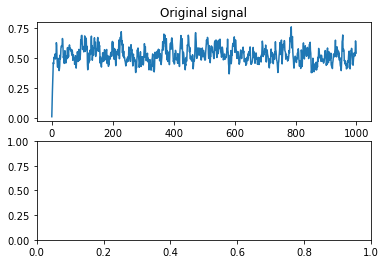

In [40]:
import torch
from torch.autograd import Variable
import torch.optim as optim
import argparse
from torch.nn.init import kaiming_uniform_
from torch.nn import Linear, Sigmoid, Module,ReLU,Sigmoid,BatchNorm1d
batch_size = 1000
learning_rate=0.0001
res_length=1000
dims=44
Fc=[i for i in range(dims)]
Dc=[i for i in range(dims)]            
for i in range(dims):
    Fc[i]=Variable(torch.from_numpy(np.random.random([batch_size, batch_size*2]) - 0.5).to(torch.float32),requires_grad=True)
    Dc[i]=Variable(torch.from_numpy(np.random.random([batch_size, batch_size]) - 0.5).to(torch.float32),requires_grad=True)
BN1=BatchNorm1d(1, eps=1e-8, momentum=0.1, affine=True, track_running_stats=True)
def print_grad(grad):
    grad_list.append(grad)

losses = []
rmses = []
#Fc=[Fc1,Fc2]
tvals = np.arange(batch_size).reshape([-1, 1])
freqs = np.arange(batch_size).reshape([1, -1])
print(tvals.shape,freqs.shape)
arg_vals = np.squeeze(torch.tensor([2 * np.pi * tvals * freqs / batch_size]).to(torch.float32))
print('arg_vals shape is',arg_vals.shape)
x=torch.from_numpy(DS.train_dl[:1000,:dims].T.reshape(dims,-1)).to(torch.float32)
sinusoids=torch.zeros(signal_length,signal_length).to(torch.float32)
#reconstructed_signal_lis=[]
#phases_lis=[]
#amplitudes_lis=[]
#sinusoids_lis=[]
for dim in range(dims):
    optimizer = optim.SGD([Fc[dim]], lr = 0.1)
    for i in range(4000):
        optimizer.zero_grad()
        data=x[dim,:].reshape(1,-1)
    #x = torch.from_numpy(np.random.random([1, signal_length]) - 0.5).to(torch.float32)
    #print('x shape is',x.shape)
    #print('W_learned shape is',Fc1.shape)
        y_pred = torch.matmul(data.view(1,-1), Fc[dim])
        #print(y_pred.shape)
        y_real = torch.squeeze(y_pred[:, 0:batch_size])
        y_imag = torch.squeeze(y_pred[:, batch_size:])
        #print('y_pred.shape is',y_pred.shape,'y_real.shape is',y_real.shape,'y_imag.shape is',y_imag.shape)
        amplitudes = (torch.sqrt(y_real**2 + y_imag**2) / batch_size)
        phases = torch.atan2(y_imag, y_real)
        #print('phases.shape',phases.shape)
        #print('amplitudes shape is',amplitudes.shape)
        #print('arg_vals[i] shape is',arg_vals[0].shape)
    #for i in range(dim):
        sinusoids = amplitudes * torch.cos(arg_vals + phases)
        #print('sinusoids shape is',sinusoids.shape)
        reconstructed_signal = torch.sum(sinusoids,axis=1)
        #print('reconstructed_signal shape is',reconstructed_signal.shape)
        loss = torch.sum(torch.square(data - reconstructed_signal))
    #print('loss shape is',loss.shape)
    #W_learned.data[i,:,:].requires_grad=True
    #y.register_hook(print_grad)
        loss.backward(retain_graph=True)
        optimizer.step()
        if i%100==1:
            print(i)
            print('now the epoch,',str(i),'with loss ',loss)
            losses.append(loss)
            if loss<1e-6:
                break                
    #reconstructed_signal_lis.append(reconstructed_signal)
    #phases_lis.append(phases)
    #amplitudes_lis.append(amplitudes)
    #sinusoids_lis.append(sinusoids)
for i in range(dims):
    print('rmse:', torch.sqrt(torch.mean((x.detach() - reconstructed_signal.detach())**2)))
    plt.subplot(2, 1, 1)
#    print(torch.squeeze(x[i,:,:1000]).shape)
    plt.plot(torch.squeeze(x[i,:1000]))
    plt.title('Original signal')
    plt.subplot(2, 1, 2)
    plt.plot(reconstructed_signal_lis[i][:1000].detach())
    plt.title('Signal reconstructed from sinusoids after DFT')
    plt.tight_layout()
    plt.show()

layer = nn.Sequential(
            nn.Linear(input_dim, n_hidden_1),
            nn.ReLU(True),
            nn.BatchNorm1d(n_hidden_1),
    
            nn.Linear(n_hidden_1, n_hidden_2),
            nn.ReLU(True),
            nn.BatchNorm1d(n_hidden_2),
            nn.Linear(n_hidden_2, output_dim) 
             )
self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(stride=2,kernel_size=2))
 
self.dense = torch.nn.Sequential(
            torch.nn.Linear(14*14*128,1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(p = 0.5),
            torch.nn.Linear(1024,10)
        )

In [13]:
rsl,pl,al,sl=reconstructed_signal_lis,phases_lis,amplitudes_lis,sinusoids_lis
print(len(rsl))
print(len(pl))
print(len(al))
print(len(sl))

NameError: name 'rsl' is not defined

In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose


def PCA_svd(X, k, center=True):
    n = X.size()[0]
    ones = torch.ones(n).view([n,1])
    h = ((1/n) * torch.mm(ones, ones.t())) if center  else torch.zeros(n*n).view([n,n])
    H = torch.eye(n) - h
    X_center= torch.mm(H.double(), X.double())
    u, s, v = torch.svd(X_center)
    print('u.shape is',u.shape,'s.shape is',s.shape,'v.shape is',v.shape)
    components  = s[:k].t()
  #explained_variance = torch.mul(s[:k], s[:k])/(n-1)
    return u,components,v

dims=44
data=torch.from_numpy(DS.train_dl[:1000,:dims].T.reshape(dims,-1)).to(torch.float32)
ori_data=torch.from_numpy(DS.ori_data[:1000,:dims].T.reshape(dims,-1)).to(torch.float32)

tvals = np.arange(batch_size).reshape([-1, 1])
freqs = np.arange(batch_size).reshape([1, -1])
arg_vals = torch.tensor([2 * np.pi * tvals * freqs / batch_size]).detach().squeeze()
dims=44
print(pl[0].shape)
print(rsl[0].shape)
print(al[0].shape)
print(arg_vals.shape)
print(torch.max(sinusoids_lis[0],1)[0].shape)
period=[]
for dim in range(len(reconstructed_signal_lis)):
    #data=x[dim,:].reshape(1,-1)
    y_pred = torch.matmul(data, Fc[dim])
    #print('y_pred.shape',y_pred.shape,'arg_vals.shape',arg_vals.shape)
    y_rael=Fc[dim][:,:batch_size].detach()
    y_imag=Fc[dim][:,batch_size:2*batch_size].detach()
    res=y_real*torch.cos(arg_vals)-y_imag*torch.sin(arg_vals)
    #feature_real = PCA_svd(y_real, 10)
    #feature_real = feature_real.float()
    #print('feature_real.shape',feature_real.shape,feature_real)
    plt.plot(ori_data[dim][0:1000].detach())
    plt.title('original_signal_lis')
    plt.show()
    plt.plot(data[dim][0:1000].detach())
    plt.title('Input_signal_lis')
    plt.show()
    plt.plot(rsl[dim][0:1000].detach())
    plt.title('reconstructed_signal_lis')
    plt.show()
    plt.plot(sl[dim][:,0:batch_size//2].detach())
    plt.title('sinusoids_lis')
    plt.show()
    #Index=np.array([1]+[i for i in range(4,200,4)])
    res=torch.sum(sl[dim][:,:],axis=1)
    zero = torch.zeros_like(res)
    Index=torch.where(res>0.01,zero,res)
    plt.plot(Index.detach())
    #plt.plot(torch.sum(sinusoids_lis[dim][:,Index],axis=1).detach())
    plt.title('sinusoids_lis.filter')
    plt.show()
    if al[dim][1:].argmax()+1<batch_size//2:
        period.append(al[dim][1:].argmax()+1)
    else:
        period.append(batch_size-al[dim][1:].argmax()-1)
    res=torch.max(sl[dim],0)[0][1:]
    print(max(res))
    #plt.plot(amplitudes_lis[dim][0:1000].detach())
    #print('amplitudes_lis',abs(amplitudes_lis[dim][0:batch_size//2]))
    print('amplitudes_lis.max',amplitudes_lis[dim][1:].argmax()+1,amplitudes_lis[dim][amplitudes_lis[dim][1:].argmax()+1])
    print('sinusoids_lis.max',res[:batch_size//2].argmax()+1,res[res[:batch_size//2].argmax()])
    plt.plot(sl[dim][:,res.argmax()+1].detach())
    plt.title('sinusoids_lis.max')
    plt.show()
    result = seasonal_decompose(data[dim], model='additive',period=250)
    plt.plot(result.trend)
    plt.title('trend')
    plt.show()
    plt.plot(result.seasonal)
    plt.title('seasonal')
    plt.show()    
    plt.plot(result.resid)
    plt.title('resid')
    plt.show()    
    plt.plot(result.observed)
    plt.title('observed')
    plt.show()  
    #print('sinusoids_lis',sinusoids_lis[dim][0:batch_size//2,:].max(axis=0))
    #plt.title('amplitudes_lis')
    #plt.show()
    #plt.plot(phases_lis[dim][0:1000].detach())
    #plt.title('phases_lis')
    #plt.show()
    #plt.matshow(np.squeeze(Fc[dim][:,:signal_length].detach().numpy()))
    #plt.title('weight_matrix')
    #plt.show()
    #plt.matshow(np.squeeze(Fc[dim][:,signal_length:2*signal_length].detach().numpy()))
    #plt.show()

def majorityCnt(classList):
    '''返回标签列表中最多的标签'''
    count_dict = {}
    for label in classList:
        if label not in count_dict.keys():
            count_dict[label] = 0
        count_dict[label] += 1
    # print(count_dict)
    return max(zip(count_dict.values(), count_dict.keys()))[1]




pr=np.array(torch.hstack(period))
hg=np.bincount(pr)
period=np.where(hg==np.bincount(pr).max())
print('period is',period)
   

NameError: name 'torch' is not defined

In [ ]:
    dim=1
    sinu=sinusoids_lis[dim][0:1000,:1000].detach().numpy()
    print(sinu.shape)
    res_sin=sinu[sinu.max(axis=0)>1e-3]
    plt.plot(sinu.sum(axis=1))
    plt.title('sum_lis')
    plt.show()
    plt.plot(res_sin.sum(axis=1))
    plt.title('res_sin')
    plt.show()
    print(res_sin.shape)

    #for i in range(100):
       # plt.plot(sinusoids_lis[dim][0:1000,i].detach())
        #plt.title('sinusoids_lis')
        #plt.show()


In [16]:
import torch
from torch.autograd import Variable
import torch.optim as optim
import argparse
from torch import Tensor,nn
from torch.nn import Linear, Sigmoid, Module,ReLU,Sigmoid,BatchNorm1d
from torchkeras import summary
import torch, gensim
torch.manual_seed(3)
from Data_Utils import *
from Plot_Utils import *
signal_length = 1000
learning_rate=0.0001
res_length=1000
dims=4
#parser = argparse.ArgumentParser()
#parser.add_argument('--batch_size', type=int, default=1000)
#args = parser.parse_args()
#args.dim=1000
from torch.nn.init import kaiming_uniform_

dims=4
dim=3


class FT_model(Module):
    def __init__(self,dims, batch_size):
        super(FT_model,self).__init__()
        self.dims=44
        self.batch_size=batch_size
        tvals = np.arange(batch_size).reshape([-1, 1])
        freqs = np.arange(batch_size).reshape([1, -1])
        self.arg_vals = torch.tensor([2 * np.pi * tvals * freqs / self.batch_size]).to(torch.float32).squeeze()
        self.lr=0.001
        self.Fc=[i for i in range(self.dims)]
        for i in range(self.dims):
            self.Fc[i]=Variable(torch.from_numpy(np.random.random([self.batch_size, self.batch_size*2]) - 0.5).to(torch.float32),requires_grad=True)
        self.y_pred=None
        #self.BN1=BatchNorm1d([self.batch_size,1], eps=1e-8, momentum=0.1, affine=True, track_running_stats=False)
        self.h1 = Linear(126*2-1,self.batch_size*5)
        kaiming_uniform_(self.h1.weight)
        self.act1 = Sigmoid()
        self.h2 = Linear(self.batch_size*5, self.batch_size*2)
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1,1,kernel_size=1,stride=2,padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(1,1,kernel_size=1,stride=2,padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(stride=1,kernel_size=2))
        
    def forward(self,X):
        #if self.y_pred is not None:
        #   y_pred_now=self.ecoder(X)
        #   y_pred=(self.lr*y_pred_now+self.y_pred)/(1+self.lr)
        #   self.y_pred=y_pred
        #else:
        X=self.ecoder(X)
        X=self.conv1(X.view(1,1,2,-1))
        #print(X.shape)
        #    self.y_pred=y_pred
        X = self.h1(X.view(1,-1))
        X = self.act1(X)
        X = self.h2(X)
        res=self.decoder(X)
        return res
        
    def ecoder(self,X):
        optimizer = optim.SGD([self.Fc[dim]], lr = 0.1)
        for i in range(2000):
            optimizer.zero_grad()
            e_pred = torch.matmul(X.view(1,-1),self.Fc[dim])
            e_real = e_pred[:, 0:self.batch_size]
            e_imag = e_pred[:, self.batch_size:]
            e_amp = (torch.sqrt(e_real**2 + e_imag**2) / self.batch_size).to(torch.float32)
            e_phases = torch.atan2(e_imag, e_real)
            e_sinusoids = e_amp * torch.cos(self.arg_vals + e_phases)
            e_reconstructed_signal = torch.sum(e_sinusoids,axis=1)
            loss = torch.sum(torch.square(X - e_reconstructed_signal))
            loss.backward(retain_graph=True)
            optimizer.step()
            if i%100==1:
                #print('In encoder, epoch',str(i),'with encoder loss ',loss)
                if loss<1e-6:
                    return e_pred
        return e_pred
    def decoder(self,X):
        d_real = X[:, 0:self.batch_size]
        d_imag = X[:, self.batch_size:]
        d_amp = (torch.sqrt(d_real**2 + d_imag**2) / self.batch_size)
        d_phases = torch.atan2(d_imag, d_real)
        #print(d_phases.shape)
        d_sinusoids = d_amp * torch.cos(self.arg_vals + d_phases)
        #print(d_sinusoids.shape)
        d_reconstructed_signal = torch.sum(d_sinusoids,axis=1)
        #print(d_reconstructed_signal.shape)
        return d_reconstructed_signal
    def decoder(self,X,n_period,stepsize):
        
        d_real = X[:, 0:self.batch_size]
        d_imag = X[:, self.batch_size:]
        
        d_amp = (torch.sqrt(d_real**2 + d_imag**2) / self.batch_size)
        d_phases = torch.atan2(d_imag, d_real)
        #print(d_phases.shape)
        d_sinusoids = d_amp * torch.cos(self.arg_vals + d_phases)
        #print(d_sinusoids.shape)
        d_reconstructed_signal = torch.sum(d_sinusoids,axis=1)
        #print(d_reconstructed_signal.shape)
        return d_reconstructed_signal

FT=FT_model(dim,signal_length)
optimizer = optim.SGD(FT.parameters(), lr = 0.01)
x=torch.from_numpy(DS.ori_data[:1000*200,:dims].T.reshape(dims,-1)).to(torch.float32)
losses=[]
loss0=0
for epoch in range(300):
    t=1000
    losses=[]
    for i in range(10):
        optimizer.zero_grad()
        data=x[3,i*t:(i+1)*t]
        reconstructed_signal=FT(data)
        target=x[3,(i+1)*t:(i+2)*t].reshape(1,-1)
        loss = torch.sum(torch.square(target - reconstructed_signal))
        loss.backward(retain_graph=True)
        optimizer.step()
        if i%2==0:
            print('now the training epoch',epoch,'with step',str(i),', loss ',loss)
            losses.append(loss.detach())
    print('Now the loss is',sum(losses))
    if abs(loss0-sum(losses))<1e-6:
        loss0=sum(losses)
        break                


now the training epoch 0 with step 0 , loss  tensor(549.5128, grad_fn=<SumBackward0>)
now the training epoch 0 with step 2 , loss  tensor(488.4739, grad_fn=<SumBackward0>)
now the training epoch 0 with step 4 , loss  tensor(421.3393, grad_fn=<SumBackward0>)
now the training epoch 0 with step 6 , loss  tensor(346.9159, grad_fn=<SumBackward0>)
now the training epoch 0 with step 8 , loss  tensor(273.0012, grad_fn=<SumBackward0>)
Now the loss is tensor(2079.2432)
now the training epoch 1 with step 0 , loss  tensor(249.1791, grad_fn=<SumBackward0>)
now the training epoch 1 with step 2 , loss  tensor(164.1662, grad_fn=<SumBackward0>)
now the training epoch 1 with step 4 , loss  tensor(119.9476, grad_fn=<SumBackward0>)
now the training epoch 1 with step 6 , loss  tensor(89.7040, grad_fn=<SumBackward0>)
now the training epoch 1 with step 8 , loss  tensor(67.1620, grad_fn=<SumBackward0>)
Now the loss is tensor(690.1589)
now the training epoch 2 with step 0 , loss  tensor(81.0390, grad_fn=<SumBa

now the training epoch 18 with step 0 , loss  tensor(3.2377, grad_fn=<SumBackward0>)
now the training epoch 18 with step 2 , loss  tensor(2.0174, grad_fn=<SumBackward0>)
now the training epoch 18 with step 4 , loss  tensor(1.8175, grad_fn=<SumBackward0>)
now the training epoch 18 with step 6 , loss  tensor(1.8336, grad_fn=<SumBackward0>)
now the training epoch 18 with step 8 , loss  tensor(1.9519, grad_fn=<SumBackward0>)
Now the loss is tensor(10.8581)
now the training epoch 19 with step 0 , loss  tensor(3.1544, grad_fn=<SumBackward0>)
now the training epoch 19 with step 2 , loss  tensor(2.0162, grad_fn=<SumBackward0>)
now the training epoch 19 with step 4 , loss  tensor(1.8144, grad_fn=<SumBackward0>)
now the training epoch 19 with step 6 , loss  tensor(1.8300, grad_fn=<SumBackward0>)
now the training epoch 19 with step 8 , loss  tensor(1.9489, grad_fn=<SumBackward0>)
Now the loss is tensor(10.7640)
now the training epoch 20 with step 0 , loss  tensor(3.0777, grad_fn=<SumBackward0>)
n

KeyboardInterrupt: 

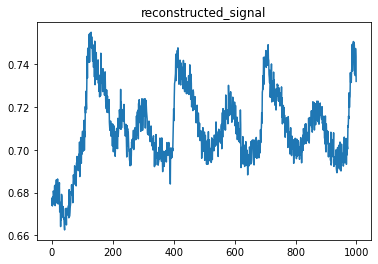

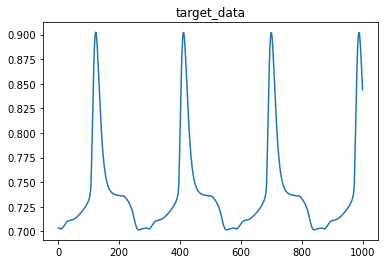

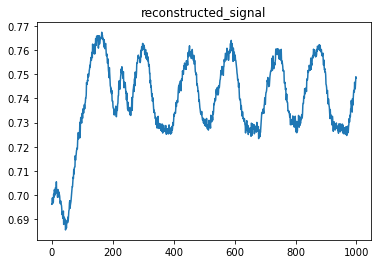

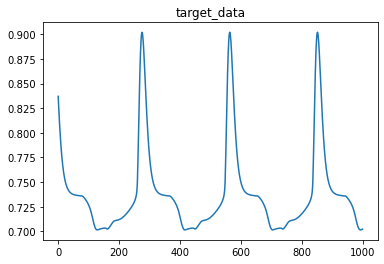

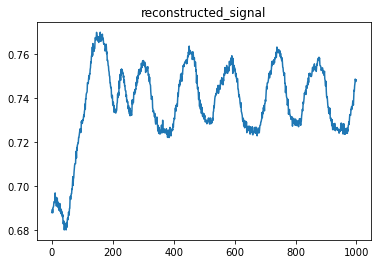

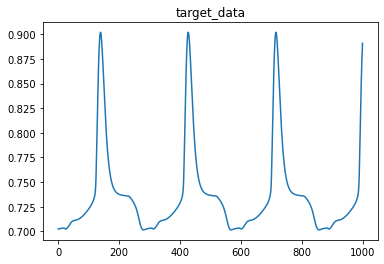

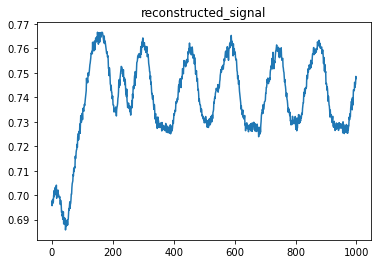

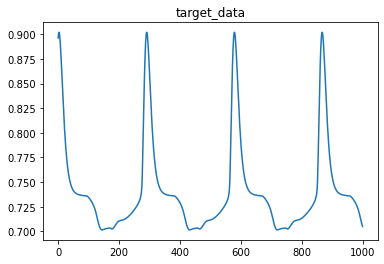

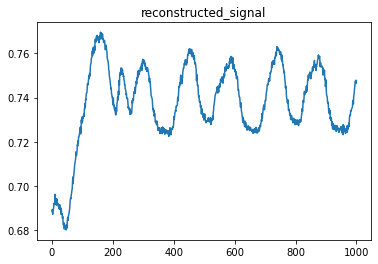

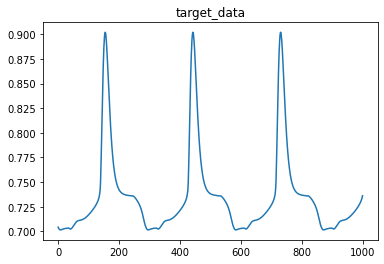

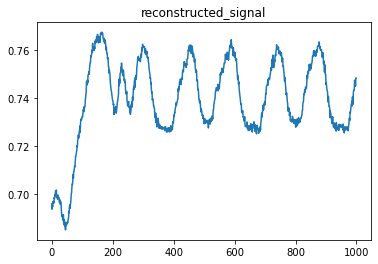

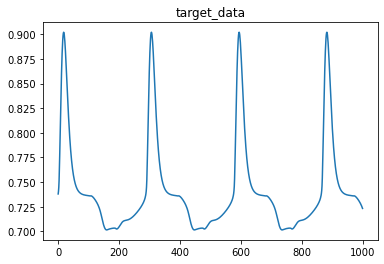

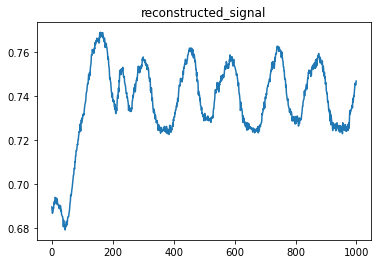

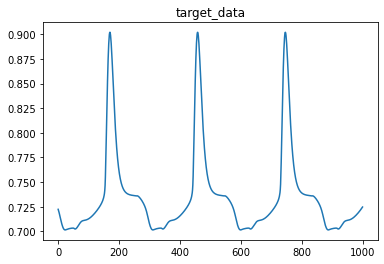

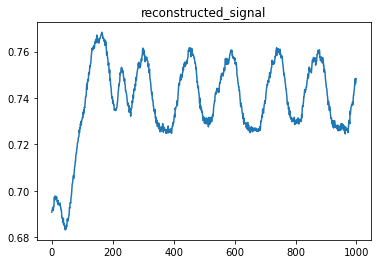

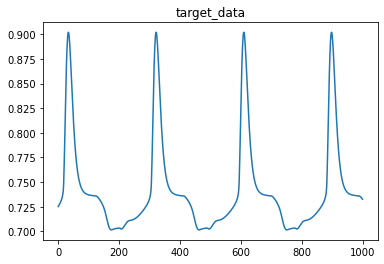

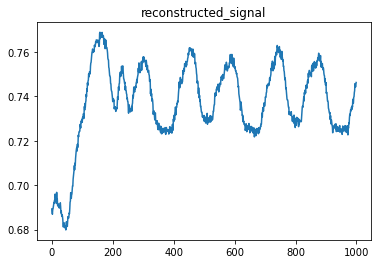

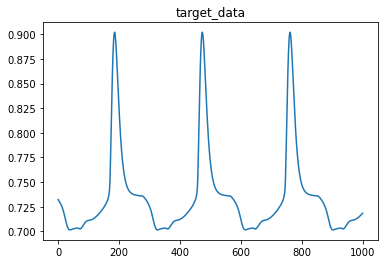

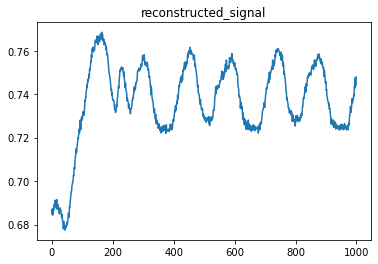

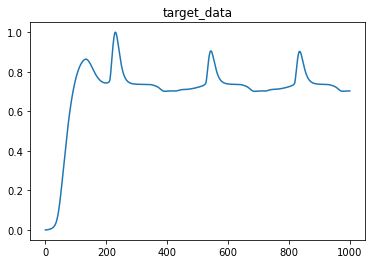

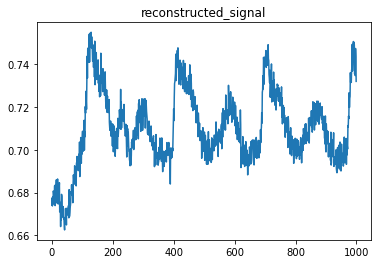

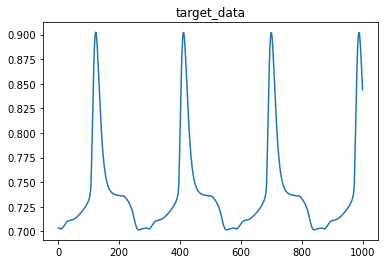

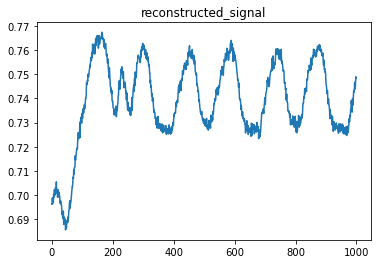

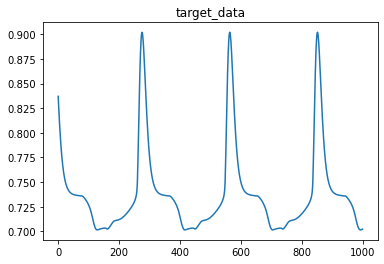

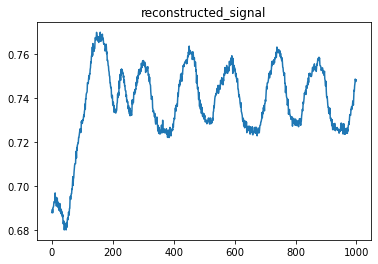

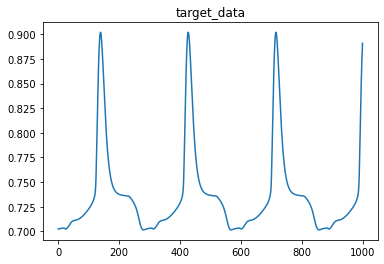

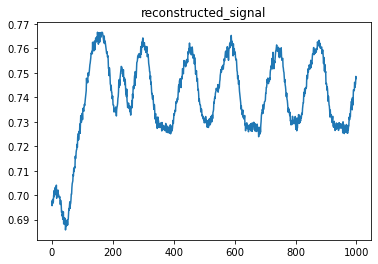

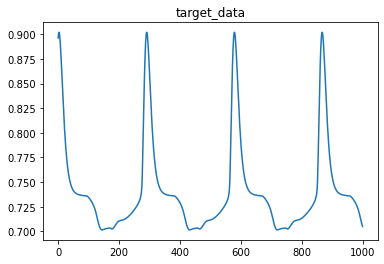

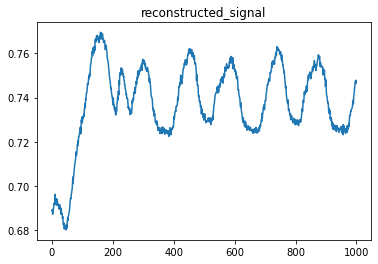

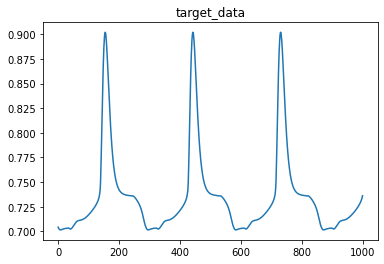

In [18]:
n=15
dim=3
x=torch.from_numpy(DS.ori_data[:1000*200,:dims].T.reshape(dims,-1)).to(torch.float32)
for i in range(n):
    data=x[dim,i*t:(i+1)*t].reshape(1,-1)
    target=x[dim,i*t+t:(i+2)*t]
    reconstructed_signal=FT(data)
    plt.plot(reconstructed_signal.detach())
    plt.title('reconstructed_signal')
    plt.show()
    plt.plot(target)
    plt.title('target_data')
    plt.show()


(100000, 44)


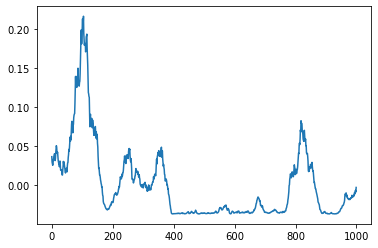

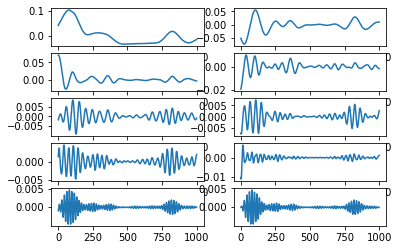

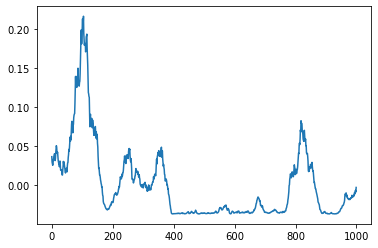

In [5]:
import numpy as np
import matplotlib.pyplot as plt

dim=1
print(DS.ori_data.shape)
series = DS.train_dl[1000:2000,dim]
#series = DS.train_dl[1000:2000,dim]
series = series - np.mean(series)   # 中心化(非必须)

# step1 嵌入
windowLen = 100              # 嵌入窗口长度
seriesLen = len(series)     # 序列长度
K = seriesLen - windowLen + 1
X = np.zeros((windowLen, K))
for i in range(K):
    X[:, i] = series[i:i + windowLen]

# step2: svd分解， U和sigma已经按升序排序
U, sigma, VT = np.linalg.svd(X, full_matrices=False)

for i in range(VT.shape[0]):
    VT[i, :] *= sigma[i]
A = VT

# 重组
rec = np.zeros((windowLen, seriesLen))
for i in range(windowLen):
    for j in range(windowLen-1):
        for m in range(j+1):
            rec[i, j] += A[i, j-m] * U[m, i]
        rec[i, j] /= (j+1)
    for j in range(windowLen-1, seriesLen - windowLen + 1):
        for m in range(windowLen):
            rec[i, j] += A[i, j-m] * U[m, i]
        rec[i, j] /= windowLen
    for j in range(seriesLen - windowLen + 1, seriesLen):
        for m in range(j-seriesLen+windowLen, windowLen):
            rec[i, j] += A[i, j - m] * U[m, i]
        rec[i, j] /= (seriesLen - j)
        
rrr = np.sum(rec[0:], axis=0)  # 选择重构的部分，这里选了全部

plt.figure(2)
plt.plot(rrr)
plt.show()

plt.figure()
for i in range(10):
    ax = plt.subplot(5,2,i+1)
    ax.plot(rec[i, :])

plt.figure(2)
plt.plot(series)
plt.show()